必要なパッケージをインポートする

In [ ]:
!pip install dwave-ocean-sdk

In [ ]:
import dimod
from dwave.embedding import MinimizeEnergy, embed_bqm,embed_qubo, unembed_sampleset
from dwave.system import DWaveSampler
import minorminer

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

QUBOを作成する。

ここではhttps://qard.is.tohoku.ac.jp/T-Wave/?p=884 の(1),(2)式を使い、縦と横で1が重ならないようなものを作成

In [ ]:
k=8#QUBOのサイズ　ここでは行、列のサイズがk*kのものを作る。
Q = {}#QUBO行列
S = {}#隣接行列。Q(i,j)が非0→1　とする
for i1 in range(k):
  for j1 in range(k):
    s1 = i1*k+j1
    for i2 in range(i1,k):
      for j2 in range(j1,k):
        s2 = i2*k+j2
        if(s1!=s2):
          if (i1==i2) or (j1==j2):
            S[(s1,s2)] = 1
            Q[(s1,s2)] = 2
    Q[(s1,s1)] =-2
    S[(s1,s1)]=1

QUBO行列を可視化する関数

In [ ]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

実行結果

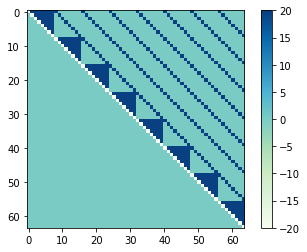

In [ ]:
show_qubo(Q)

D-waveマシンにアクセスし、出力をもらう

In [ ]:
url = "https://cloud.dwavesys.com/sapi"#webAPIでアクセスするurl
token = ""# Fill your API token
solver_name = "DW_2000Q_6"# Choose a solver such as DW_2000Q_6
num_reads = 1000#アニーリングを実行する回数
sampler = DWaveSampler(endpoint=url, token=token, solver=solver_name)

#minorminerを使って、論理ビットをキメラグラフへ埋め込む
embedding = minorminer.find_embedding(S, sampler.edgelist) 

bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
bqm_embed = embed_bqm(bqm, embedding, sampler.adjacency)
#d-waveにアクセスして、結果をもらう
result = sampler.sample(bqm_embed, num_reads = num_reads)
#後処理をする。埋め込みされた結果→もとの論理ビットへ
cbm = MinimizeEnergy(bqm, embedding)
sample = unembed_sampleset(result, embedding, bqm, chain_break_method=cbm)
#一番エネルギーが低い解を表示する。energy→解のエネルギー、sample→解
print(sample.lowest().record["energy"][0])
sample1 = sample.lowest().record['sample'][0]
for i in range(k):
  print(*sample1[k*i:k*(i+1)],sep="")

-160.0
10000000
00001000
01000000
00010000
00100000
00000100
00000010
00000001
